In [31]:
# Import required packages
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
import copy

from project_ENGIE import Project_Engie
from operational_analysis.methods import plant_analysis
import operational_analysis.toolkits.machine_learning_setup as ml
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import feature_selection

In [2]:
# Load plant object and prepare data
project = Project_Engie('./data/la_haute_borne')
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [4]:
# Take a look at the revenue meter data that will be the basis of the AEP analysis
project._meter.df.tail()

,energy_kwh,time
time,,
2015-12-31 23:10:00,147.141,2015-12-31 23:10:00
2015-12-31 23:20:00,194.842,2015-12-31 23:20:00
2015-12-31 23:30:00,180.688,2015-12-31 23:30:00
2015-12-31 23:40:00,149.039,2015-12-31 23:40:00
2015-12-31 23:50:00,125.091,2015-12-31 23:50:00


In [5]:
project._scada.df['id'].unique()

array(['R80736', 'R80721', 'R80790', 'R80711'], dtype=object)

### Section 4: Data Quality Control and Filtering Plots

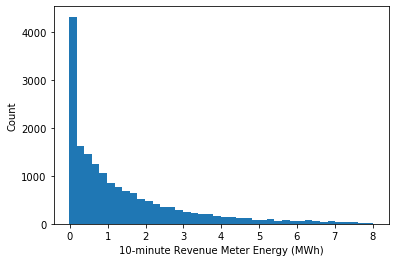

In [6]:
# Revenue meter data
df = project._meter.df.resample('H').sum() # Let's resample to hourly for simplicity
plt.hist(df['energy_kwh']/1000, 40)
plt.xlabel('10-minute Revenue Meter Energy (MWh)')
plt.ylabel('Count')
plt.savefig('/Users/moptis/Documents/awea_tr1/figures/01_rev_meter_hist.png', dpi = 600)
plt.show()

In [7]:
df.min()

energy_kwh   -24.534
dtype: float64

Checking this against the fact we have 4 x 2.05 MW turbines, we shouldn't exceed 8 MWh for any given hour. Indeed we see that this is the case. Furthermore, there are frequent periods of zero power production, which we also expect.

In [41]:
# Now create an AEP analysis object that uses daily resolution and the ERA-5 reanalysis product
pa_daily = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2'], time_resolution = 'D', 
                                        reg_temperature = True, reg_winddirection = True,
                                        reg_model = 'etr')

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


In [48]:
# Let's look at the result
pa_daily._aggregate.df.head()

,energy_gwh,energy_nan_perc,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,merra2,merra2_temperature_K,merra2_u_ms,merra2_v_ms,merra2_wd
time,,,,,,,,,,,,,,,,,,
2014-01-01,0.072340,0.0,0.000022,0.0,0.072363,0.000310,0.0,0.0,0.0,False,True,True,True,9.852159,277.863155,2.166567,9.245650,3.371773
2014-01-02,0.084852,0.0,0.000048,0.0,0.084901,0.000570,0.0,0.0,0.0,False,True,True,True,11.024592,279.679223,5.895272,8.800658,3.731808
2014-01-03,0.091516,0.0,0.000000,0.0,0.091516,0.000000,0.0,0.0,0.0,False,True,True,True,10.476681,279.755816,4.140354,9.346870,3.558582
2014-01-04,0.041096,0.0,0.000008,0.0,0.041104,0.000201,0.0,0.0,0.0,False,True,True,True,8.068651,278.333780,-0.907260,7.558704,3.022136
2014-01-05,0.048664,0.0,0.000000,0.0,0.048664,0.000000,0.0,0.0,0.0,False,True,True,True,7.932043,276.317558,4.858803,4.719581,3.941525


In [49]:
df = pa_daily._aggregate.df
df['merra2_wd'] = df['merra2_wd'] * 180 / np.pi
df['merra2_temperature_K'] = df['merra2_temperature_K'] - 273.16

df = pa_daily._reanalysis_aggregate
df['merra2_wd'] = df['merra2_wd'] * 180 / np.pi
df['merra2_temperature_K'] = df['merra2_temperature_K'] - 273.16

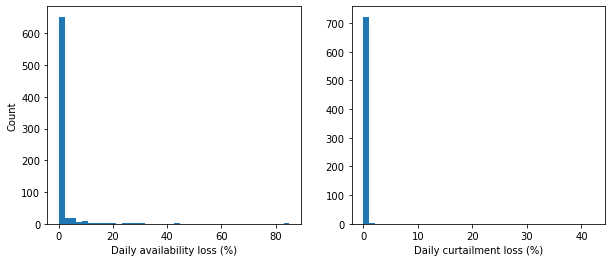

In [50]:
# Histograms of availability and curtailment losses on daily scale
df = pa_daily._aggregate.df

fig, ax = plt.subplots(1, 2, figsize = (10,4)) 

ax[0].hist(df['availability_pct'] * 100, 40)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Daily availability loss (%)')

ax[1].hist(df['curtailment_pct'] * 100, 40)
ax[1].set_xlabel('Daily curtailment loss (%)')
plt.savefig('/Users/moptis/Documents/awea_tr1/figures/02_avail_curt_hist.png', dpi = 600)
plt.show()

In [51]:
np.mean(df['availability_pct'])
np.mean(df['curtailment_pct'])

0.0008676411725617399

As we'd expect, losses are usually 0% but occassionally go as high as 80%. In general losses for these 4 turbines at La Haute are very low.

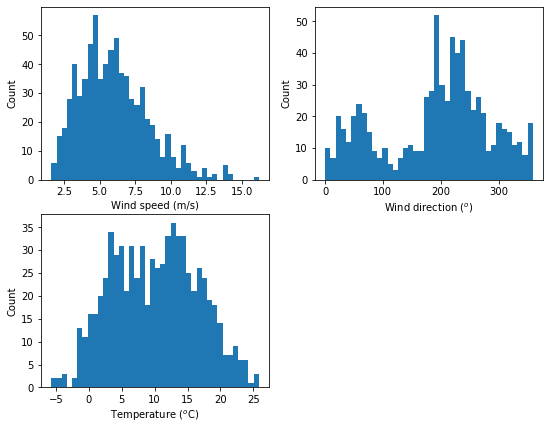

In [52]:
# Examine wind speed, wind direction, and temperature distributions from the ERA-5 data set
df = pa_daily._aggregate.df

fig, ax = plt.subplots(2,2, figsize = (9,7))

ax[0,0].hist(df['merra2'], 40)
ax[0,0].set_xlabel('Wind speed (m/s)')
ax[0,0].set_ylabel('Count')

ax[0,1].hist(df['merra2_wd'], 40)
ax[0,1].set_xlabel('Wind direction ($^o$)')
ax[0,1].set_ylabel('Count')

ax[1,0].hist(df['merra2_temperature_K'], 40)
ax[1,0].set_xlabel('Temperature ($^o$C)')
ax[1,0].set_ylabel('Count')

ax[1,1].axis('off')

plt.savefig('/Users/moptis/Documents/awea_tr1/figures/03_met_vars_hist.png', dpi = 400)
plt.show()

### Feature Importance

In [53]:
X = df[['merra2', 'merra2_wd', 'merra2_temperature_K']]
y = df['energy_gwh']

In [15]:
# Define r2 scorer
def r2_scorer(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

In [16]:
# Setup up ML model for hyperparameter optimization
mod = ml.MachineLearningSetup(algorithm='etr')
mod.my_scorer = make_scorer(r2_scorer, greater_is_better = True)

In [17]:
mod.hyper_optimize(X,y, n_iter_search = 20)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.9s finished


Model with rank: 1

Mean validation score: 0.944 (std: 0.010)

Parameters: {'n_estimators': 650, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}


Model with rank: 2

Mean validation score: 0.943 (std: 0.009)

Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 12}


Model with rank: 3

Mean validation score: 0.943 (std: 0.009)

Parameters: {'n_estimators': 650, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 16}


Model with rank: 4

Mean validation score: 0.943 (std: 0.009)

Parameters: {'n_estimators': 490, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 16}


Model with rank: 5

Mean validation score: 0.943 (std: 0.010)

Parameters: {'n_estimators': 370, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 12}


Model with rank: 6

Mean validation score: 0.943 (std: 0.009)

Parameters: {'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}


Model with rank: 7



In [18]:
# Save best result
params = {'n_estimators': 490, 'min_samples_split': 8, 'max_depth': 12, 'min_samples_leaf': 2}

In [19]:
mod2 = ExtraTreesRegressor(**params)
mod2.fit(X, y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=12, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=8, min_weight_fraction_leaf=0.0,
                    n_estimators=490, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [20]:
# Output feature importance from ETR
pd.DataFrame(index = X.columns, data = {'importance': mod2.feature_importances_})

,importance
merra2,0.953243
merra2_wd,0.030089
merra2_temperature_K,0.016668


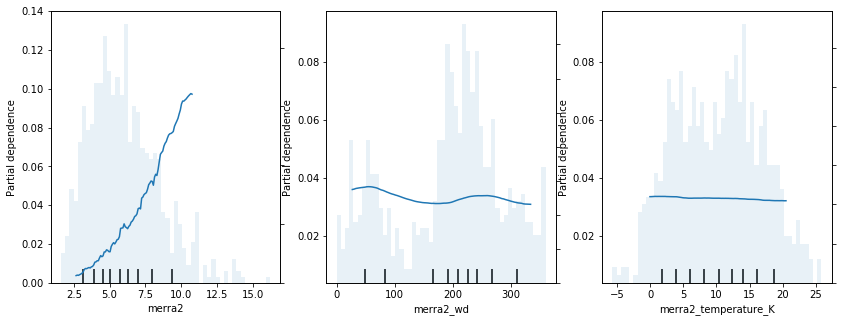

In [24]:
from sklearn.inspection import plot_partial_dependence

features = [0, 1, 2]

fig, ax = plt.subplots(1,3,figsize=(14,5))
plot_partial_dependence(mod2, X, features, ax = ax) 

ax[0].set_ylim(0, 0.14)

for a in np.arange(3):
    ax2 = ax[a].twinx()
    ax2.hist(X.iloc[:,a],50, alpha = 0.1)
    ax2.set_yticklabels([])


In [59]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [86]:
#input_cols = ["WS at 65 m AGL [$m\: s^{-1}$]", "time [UTC]", "time [UTC]", "WS at 4 m AGL [$m\: s^{-1}$]", "L$^{-1}$ [$m^{-1}$]", "TKE [$m^2\: s^{-2}$]"]
input_cols = ['50-m wind speed', '50-m wind direction', '50-m temperature']

In [87]:
pd_count = 200 # number of values to sample for each input
var_vals = np.zeros((len(input_cols), pd_count))
futures = []
# Loop across all inputs
for i in range(len(input_cols)):
    # Equally spaced grid of input values
    var_vals[i] = np.linspace(X.iloc[:, i].min(), X.iloc[:, i].max(), 200)    
    # Partial dep analysis
    futures.append(partial_dependence_1d(X, mod2, i, var_vals[i]))

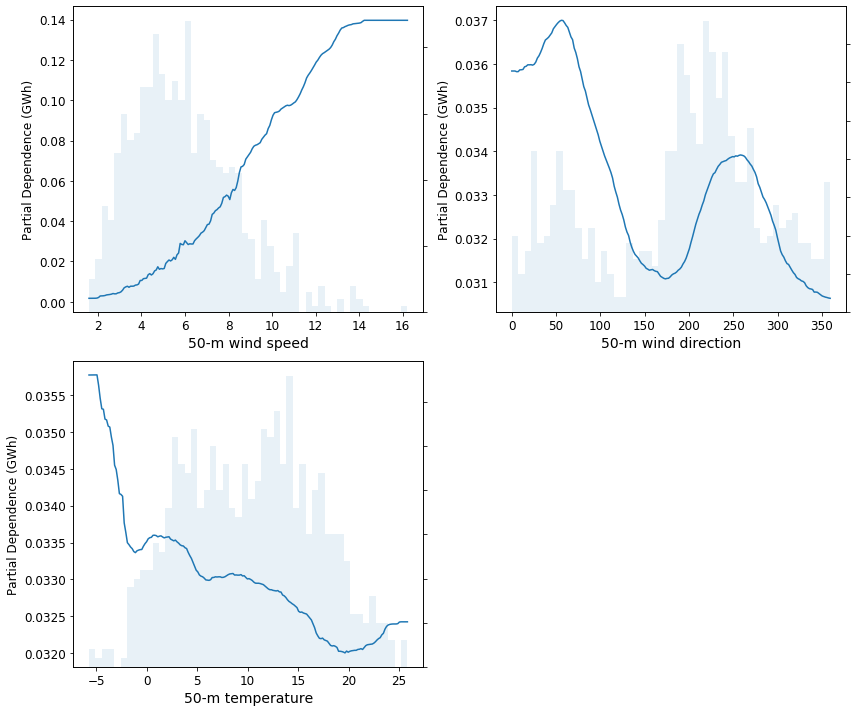

In [104]:
plt.figure(figsize=(12, 10))

plt.tight_layout()

subplot_count = 1
for r in range(len(input_cols)):
    ax = plt.subplot(2,2,subplot_count)
    plt.plot(var_vals[r], futures[r])
    plt.xlabel(input_cols[r], fontsize=14)
    plt.ylabel('Partial Dependence (GWh)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax2 = ax.twinx()
    ax2.hist(X.iloc[:,r],50, alpha = 0.1)
    ax2.set_yticklabels([])
    subplot_count = subplot_count+1
plt.tight_layout()
plt.savefig('/Users/moptis/Documents/awea_tr1/figures/04_pd_plots.png', dpi = 300)

In [32]:
# Report on p-values
p_values = feature_selection.f_regression(X, y, center=True)[1]
p_values

array([6.25590994e-297, 1.89892201e-001, 3.29574024e-008])

In [ ]:
# Now actually run the extra trees model and compute AEP


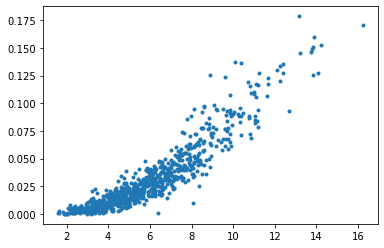

In [34]:
X_long_term = project._reanalysis.df

plt.plot(X['merra2'], y, '.', label = 'Measured data')
plt.plot()

In [35]:
X_long_term = project._reanalysis.

AttributeError: 'ReanalysisData' object has no attribute 'df'

In [42]:
pa_daily.run(num_sim=1000)

INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 1000, 'reanal_subset': ['merra2']}
  0%|          | 0/1000 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
  0%|          | 1/1000 [00:03<57:54,  3.48s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished
  0%|          | 2/1000 [00:07<59:33,  3.58s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished
  0%|          | 3/1000 [00:11<1:03:09,  3.80s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
  0%|          | 4/1000 [00:13<55:26,  3.34s/it]  [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished
  0%|          | 5/1000 [00:18<1:00:11,  3.63s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
  1%|          | 6/1000 [00:21<56:53,  3.43s/it]  [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
  1%|          | 7/1000 [00:24<58:03,  3.51s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished
  1%|          | 8/1000 [00:29<1:03:58,  3.87s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
  1%|          | 9/1000 [00:32<1:01:22,  3.72s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished
  1%|          | 10/1000 [00:38<1:10:53,  4.30s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
  1%|          | 11/1000 [00:42<1:07:35,  4.10s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished
  1%|          | 12/1000 [00:46<1:08:01,  4.13s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
  1%|▏         | 13/1000 [00:52<1:17:51,  4.73s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
  1%|▏         | 14/1000 [00:56<1:12:11,  4.39s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
  2%|▏         | 15/1000 [00:59<1:05:47,  4.01s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
  2%|▏         | 16/1000 [01:02<1:04:04,  3.91s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
  2%|▏         | 17/1000 [01:06<1:04:27,  3.93s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished
  2%|▏         | 18/1000 [01:11<1:08:47,  4.20s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished
  2%|▏         | 19/1000 [01:19<1:24:13,  5.15s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished
  2%|▏         | 20/1000 [01:23<1:20:08,  4.91s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
  2%|▏         | 21/1000 [01:26<1:12:12,  4.43s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished
  2%|▏         | 22/1000 [01:31<1:11:54,  4.41s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
  2%|▏         | 23/1000 [01:35<1:09:39,  4.28s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished
  2%|▏         | 24/1000 [01:40<1:13:07,  4.50s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
  2%|▎         | 25/1000 [01:44<1:11:15,  4.39s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished
  3%|▎         | 26/1000 [01:47<1:07:58,  4.19s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished
  3%|▎         | 27/1000 [01:53<1:12:47,  4.49s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished
  3%|▎         | 28/1000 [01:58<1:17:12,  4.77s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished
  3%|▎         | 29/1000 [02:04<1:21:55,  5.06s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
  3%|▎         | 30/1000 [02:08<1:15:11,  4.65s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished
  3%|▎         | 31/1000 [02:10<1:02:39,  3.88s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished
  3%|▎         | 32/1000 [02:15<1:07:51,  4.21s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
  3%|▎         | 33/1000 [02:19<1:09:18,  4.30s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
  3%|▎         | 34/1000 [02:23<1:05:18,  4.06s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
  4%|▎         | 35/1000 [02:25<58:49,  3.66s/it]  [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
  4%|▎         | 36/1000 [02:30<1:02:30,  3.89s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
  4%|▎         | 37/1000 [02:33<59:04,  3.68s/it]  [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished
  4%|▍         | 38/1000 [02:38<1:04:02,  3.99s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
  4%|▍         | 39/1000 [02:41<59:13,  3.70s/it]  [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
  4%|▍         | 40/1000 [02:44<55:35,  3.47s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
  4%|▍         | 41/1000 [02:46<50:20,  3.15s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
  4%|▍         | 42/1000 [02:49<47:19,  2.96s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
  4%|▍         | 43/1000 [02:52<51:29,  3.23s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
  4%|▍         | 44/1000 [02:53<41:09,  2.58s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished
  4%|▍         | 45/1000 [02:59<53:59,  3.39s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished
  5%|▍         | 46/1000 [03:04<1:02:03,  3.90s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: 

In [57]:
X_long_term = pa_daily._reanalysis_aggregate[['merra2', 'merra2_wd', 'merra2_temperature_K']]
X_long_term.dropna(inplace = True)

/Users/moptis/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
y_pred = mod2.predict(X_long_term)

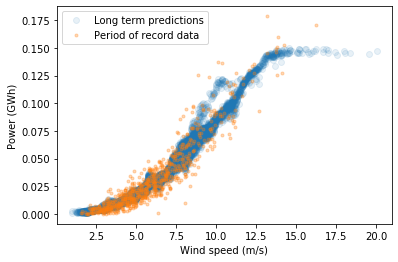

In [72]:
plt.plot(X_long_term['merra2'], y_pred, 'o', zorder = -1, alpha = 0.1, label = 'Long term predictions')
plt.plot(X['merra2'], y, '.', zorder = 0, alpha = 0.3, label = 'Period of record data')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (GWh)')
plt.legend()